In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install saliency
!pip install tensorflow-addons
!pip install fastparquet

     |████████████████████████████████| 1.1 MB 6.7 MB/s 
     |████████████████████████████████| 1.2 MB 7.3 MB/s 
     |████████████████████████████████| 1.5 MB 43.5 MB/s 
     |████████████████████████████████| 123 kB 60.8 MB/s 
     |████████████████████████████████| 59 kB 9.4 MB/s 
  Created wheel for thrift: filename=thrift-0.13.0-cp37-cp37m-linux_x86_64.whl size=348202 sha256=403f5a07b4c7397c2049029ba509ff667d5da2f0f048cea3dc8d4b7c4b6a959e
  Stored in directory: /root/.cache/pip/wheels/79/35/5a/19f5dadf91f62bd783aaa8385f700de9bc14772e09ab0f006a
Successfully built thrift


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import fastparquet as fp
import scipy.integrate as it
from collections import Counter

from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score

import tensorflow as tf
import os
import pickle
from collections import Counter
import pandas as pd
from keras.models import Model, load_model, model_from_json

from tensorflow_addons.optimizers import RectifiedAdam, Lookahead

os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from pred_functions import predict, combine_files_into_acquisitions, post_processing
from dataset_preprocessing import homogeneous_cluster_names_swings, gen_train_test_valid
from losses import CB_loss, categorical_focal_loss


os.chdir('/content/gdrive/My Drive/data/SWINGS')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#importation data
dir = "/content/gdrive/MyDrive/data/SWINGS/L2/Pulse/"

# Load the raw data
train = np.load(dir + 'train.npz', allow_pickle = True)
#valid = np.load(dir + 'valid.npz', allow_pickle = True)
#test = np.load(dir + 'test.npz', allow_pickle = True)
tn = pd.read_csv(dir + 'train_test_nomenclature.csv')

# Dispatch the data
#X_test = test['X']
#X_valid = valid['X']
X_train = train['X']
y_train = train['y']

In [ ]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P

# From our repository.
import saliency.core as saliency

%matplotlib inline

In [ ]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='magma')
  P.colorbar()
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

In [ ]:
# Load the model 
m = load_model('/content/gdrive/My Drive/Models/SWINGS/cnn_HyperCateg41')
conv_layer = m.get_layer('conv1d_77')
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

In [ ]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

# Final

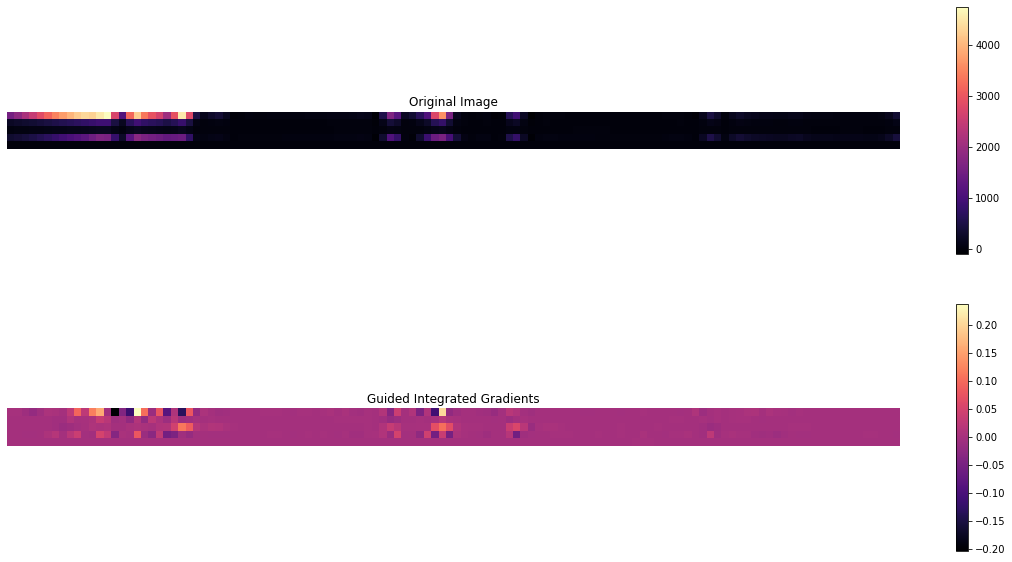

In [ ]:
micro_indices = np.where(y_train.argmax(1) == 1)[0]
micro_idx = np.random.choice(micro_indices)
# Load the image and format the arguments
im = X_train[micro_idx]

_, predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}


# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
smoothgrad_mask = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
guided_ig = saliency.GuidedIG()

# Baseline is a black image for vanilla integrated gradients.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the Guided IG mask.
guided_ig_mask = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

# Set up matplot lib figures.
ROWS = 2
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

ShowHeatMap(im.T, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
#ShowHeatMap(smoothgrad_mask.T, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))
#ShowHeatMap(smoothgrad_integrated_gradients_mask.T, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))
ShowHeatMap(guided_ig_mask.T, title='Guided Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))